In [1]:
# Packages laden
import pandas as pd
import sklearn as skl
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew
%matplotlib inline
# erkärte Variable Verteilung prüfen
# Prüfen, welche Variablen falsch skaliert sind
# nA Values bearbeiten
# Ausreißer behandeln
# Kategoriale Variablen in faktoren unterteilen bzw. 
# Kategoriale Variablen one Hot coden


In [ ]:
#Datei einlesen
#Datenstruktur und Variablen einsehen

house_data = pd.read_csv("C:/Users/Denis/OneDrive/Dokumente/Kurse/S8/angewandte Ökonometrie/housing_prices.csv", index_col = "Id")
house_data.head()
house_data.shape

skew(house_data["SalePrice"], axis=0) # Funktion zum identifizieren der Schiefe der Verteilung (aus dem scipy.stats package)
# house_data["SalePrice"].describe().to_excel("C:/Users/Denis/OneDrive/Dokumente/Kurse/S8/angewandte Ökonometrie/describe.xlsx") # hier wird die deskriptive statistik für SalePrice in meine lokale Excel-Datei exportiert



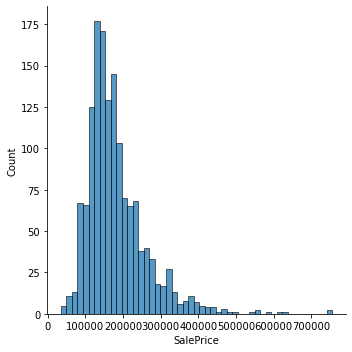

In [3]:
# deskriptive Statisitk der erklärten Variable

sns.displot(data=house_data["SalePrice"])
# house_data["SalePrice"].describe().to_excel("C:/Users/Denis/OneDrive/Dokumente/Kurse/S8/angewandte Ökonometrie/describe.xlsx") => wurde genutzt um die deskr. Statistik in ein lokales Excel Dokument zu exportieren


In [4]:
pd.options.display.max_columns = 81
df = pd.DataFrame(house_data)


# Position der erklärten Variable auf den Anfang des Datensatzes ändern (erste Spalte)
cols = list(df.columns)
cols = [cols[-1]] + cols[:-1]
df = df[cols]



In [ ]:
df_regressors = df.loc[:, df.columns != "SalePrice"]

In [ ]:
# Anzahl der Datentypen
df_regressors.dtypes.value_counts()

In [ ]:
# Missing Values Betrachtung (Credits: https://dzone.com/articles/pandas-dataframe-functionsplaying-with-multiple-da)
pd.options.display.max_rows = 81
missing_value_cnt = df.isnull().sum()

# Auflistung der Variablen mit fehlenden Werten
missing_columns = df.columns[df.isnull().any()].tolist()
missing_columns


In [ ]:
# Anzahl der fehlenden Werte in den Spalten
missing_value_cnt

In [ ]:
#numerische Variablen identifizieren und auf missing Values untersuchen

df_numerics = df.select_dtypes(include=np.number)
pd.set_option('display.max_columns', None)
#df_numerics.shape
#df_numerics
missing_columns_num = df_numerics.isnull().sum()
missing_columns_num



In [ ]:
# LotFrontage Missing Values untersuchen (Lotfrrontage is die Länge des Grundstücks, auf dem das Haus gebaut ist und das an der Straße grenzt)
df[df.LotFrontage.isna()].SalePrice.describe()
df[df.LotFrontage.isna()].SalePrice.describe().to_excel("C:/Users/Denis/OneDrive/Dokumente/Kurse/S8/angewandte Ökonometrie/describe_LotFrontage_Missing.xlsx")

In [ ]:
# Erstmal kein Hinweis auf systematisches fehlen der Einträge (Mittelwert von SalesPrice bei den Beobachtungen mit fehlendem LotFrontage = Mittelwert insgesamt), daher Mittelwert-Imputation

mean_LotFrontage = df["LotFrontage"].mean()
df['LotFrontage'] = df['LotFrontage'].fillna(mean_LotFrontage)


df_numerics = df.select_dtypes(include=np.number)
missing_columns_num = df_numerics.isnull().sum()
missing_columns_num


In [ ]:
# GarageYrBlt missing Values untersuchen: Falls in den 81 Zeilen jeweils alle "Garage" Variablen fehlen, gehe ich davon aus, dass keine Garage vorliegt. 

df_Garage = df.loc[:,['SalePrice','GarageYrBlt', 'GarageType','GarageFinish','GarageQual', 'GarageCond']]

df_GarageMissing = df_Garage
df_GarageMissing = df_GarageMissing[df_GarageMissing.isnull().any(axis=1)]
df_GarageMissing.shape
df_GarageMissing

# Tatsächlich fehlen in den beobachteten Fällen alle "Garage" Variablen gemeinsam, daher wahrscheinlich keine Garage vorhanden. 

In [ ]:
sns.scatterplot(data = df, x = 'GarageYrBlt', y = 'SalePrice') #ab ca. 1990 ist eine höhere positive Korrelation zwischen dem Baujahr und dem Preis zu sehen, daher werde ich 3 bins erstellen: keine Garage, vor 1990, nach 1990

In [ ]:
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)

sns.scatterplot(data = df, x = 'GarageYrBlt', y = 'SalePrice') #Gebäude, die einen Missing Value hatten bei Garagenvariablen, sind im Durchschnitt weniger wert. Ein Hinweis darauf, dass dort keine Garage verbaut ist

In [ ]:
# bins erstellen für GarageYrBlt: keine Garage, Garage vor 1990 gebaur, Garage nach 1990 gebaut

bins = [-1, 1, 1990, 2300]
df_bins = pd.cut(df['GarageYrBlt'].to_list(), bins)
df_bins.categories = ['None', '< 1990', '>= 1990']
df['GarageYrBlt'] = df_bins
sns.catplot(x = 'GarageYrBlt', y = 'SalePrice', data = df) 

In [ ]:
df

In [ ]:
# als nächstes MasVnrArea Missing Values behandeln

df_numerics = df.select_dtypes(include=np.number)
missing_columns_num = df_numerics.isnull().sum()
missing_columns_num


In [ ]:
# MasVnrArea Missing Values untersuchen

df['MasVnrType'].value_counts()
df_MasVnr = df[['SalePrice', 'MasVnrType', 'MasVnrArea']]
df_MasVnr


#Beobachtungen identifizieren, in denen MasVnrType Missing Values aufweist
null_data = df_MasVnr[df_MasVnr.isnull().any(axis=1)]
null_data




In [ ]:
#Beobachtungen rausnehmen, bei denen MasVnrarea fehlt

df = df.drop(index = [235, 530, 651, 937, 974, 978, 1244, 1279])
df

In [ ]:
# Nominal und Ordinal skalierte Variablen, die Nummern als Ausprägungen haben, aus der numerischen Tabelle nehmen.
df_numerics = df.select_dtypes(include=np.number)
df_numerics = df_numerics.drop(["MSSubClass", "OverallQual", "OverallCond", "MoSold", "YrSold", "YearBuilt", "YearRemodAdd"], axis = 1) #"GarageYrBlt"

In [ ]:
df.loc[(df.YearBuilt < 1950) & (df.YearRemodAdd > 1960)]
df.loc[(df.YearBuilt == df.YearRemodAdd)]

In [ ]:
# Aus Yearsold unf YearRemodAdd eine neue Variable machen: Alter des Hauses

df.YrSold.max() # 2010 wurde das letzte Haus verkauft in diesem Datensatz, daher nehme ich 2010 als aktuelles Jahr an 
#sns.scatterplot(x = 'YearRemodAdd', y = 'SalePrice', data = df)

In [ ]:
sns.regplot(x = 'YearRemodAdd', y = 'SalePrice', data = df.loc[df.YearBuilt >1970])

In [ ]:
# tendenziell scheinen ältere Häuser auch nach einer Sarnierung wenig an Wert zu haben, verglichen mit neuen Gebäuden. Für das Alter werde ich nur das Baujahr berücksichtigen.

sns.regplot(x = 'YearRemodAdd', y = 'SalePrice', data = df.loc[(df.YearRemodAdd >1950) & (df.YearBuilt < 1950)]) 

In [ ]:
df["CurrentYear"] = 2010
df["Age"] = df["CurrentYear"] - df["YearBuilt"]
df = df.drop(["CurrentYear"], axis = 1)
df_numerics["Age"] = df["Age"]
df = df.drop(['YearBuilt','YearRemodAdd'], axis = 1)

In [ ]:
df_numerics.Age

In [ ]:
# Numersiche Variablen auf Korrelationen prüfen
corr_numerics = df_numerics.corr()
corr_numerics.head()
#corr_numerics.shape

#Spalten aus der Korrelationsmatrix rausnehmen, die eine kleine Korrelation von unter 0,4 aufweisen
drop_columns = []
for i in range(0,len(df_numerics.columns)):
    if abs(corr_numerics.iloc[0][i]) < 0.4:
        drop_columns.append(i)

corr_numerics = corr_numerics.drop(corr_numerics.columns[drop_columns],axis=1)

#Zeilen aus der Korrelationsmatrix nehmen, die eine kleine Korrelation von unter 0,5 aufweisen. Jetzt wird die Korrelationsmatrix wieder quadratisch
drop_rowlabels = []
for i in drop_columns:
    drop_rowlabels.append(corr_numerics.index[i])
corr_numerics = corr_numerics.drop(drop_rowlabels)

# SalesPrice war zweimal in der korrelationsmatrix, deshalb eine SalesPrice Zeile und Spalte aus der Matrix nehmen
#corr_numerics = corr_numerics.iloc[:-1,:-1]

In [ ]:
corr_numerics.tail()
corr_numerics.shape

In [ ]:
sns.heatmap(corr_numerics, vmin = -1 , vmax = 1, annot = True, cmap = "vlag", fmt = '.1g')

In [ ]:
# da Garagecars und GarageArea beide den gleichen Effekt darstellen (Größe der garage), eliminiere ich eine der beiden (hohe Korrelation untereinander)
df = df.drop("GarageCars", axis = 1)

Die höchsten Korrelationen zur Erklärten Variable weisen OverallQual, GrLivArea und GarageCars auf. Außerdem bestehen zwischen einigen erklärenden Variablen eine hohe Korrelation. 

In [ ]:
# Ausreißer identifizieren

#sns.scatterplot(data = df, x = 'MasVnrArea', y = 'SalePrice')
#df= df[df['MasVnrArea'] < 500]
sns.scatterplot(data = df, x = 'MasVnrArea', y = 'SalePrice')

In [ ]:
#df= df[df['TotalBsmtSF'] < 5000]
sns.scatterplot(data = df, x = 'TotalBsmtSF', y = 'SalePrice')  # Ausreißer bei über 6000 qm Kellerfläche, im nächsten Schritt eliminieren


In [ ]:
#credits https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame

df = df[df['TotalBsmtSF'] < 5000] # Ausreißer mit über 6000 Quadratmeter Kellerfläche eliminieren
sns.scatterplot(data = df, x = 'TotalBsmtSF', y = 'SalePrice') 

In [ ]:
sns.scatterplot(data = df, x = '1stFlrSF', y = 'SalePrice')

In [ ]:
sns.scatterplot(data = df, x = 'FullBath', y = 'SalePrice')

In [ ]:
sns.scatterplot(data = df, x = 'TotRmsAbvGrd', y = 'SalePrice')

In [ ]:
sns.scatterplot(data = df, x = 'GarageArea', y = 'SalePrice')

In [ ]:
sns.scatterplot(data = df, x = 'Fireplaces', y = 'SalePrice')

In [ ]:
# Auflistung nominal und ordinal skalierter Variablen (credits: https://stackoverflow.com/questions/29803093/check-which-columns-in-dataframe-are-categorical)
columns_dont_want = []
for i in df_numerics:
    columns_dont_want.append(i)
select = [x for x in df.columns if x not in columns_dont_want]
#df_chars = pd.DataFrame(house_data[select])
df_chars = pd.DataFrame(df[select])
df_chars.shape



In [ ]:
df_chars.shape


In [ ]:
len(df_chars.columns)

In [ ]:
# Ordinale Variablen in einen DataFrame ziehen und kodieren für Kendalls Korrelation mit HousePrice (Credits:https://journals.sagepub.com/doi/pdf/10.1177/8756479308317006)

df_ordinals = pd.DataFrame(data = df_chars, columns = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence'])
df_ordinals.dtypes
df_ordinals

"ExterQual", "ExterCond", "HeatingQC", "KitchenQual" benutzen die selben ordinalen Kategorien. 
Darüber hinaus benutzen "BsmtQual", "BsmtCond","FireplaceQu", "GarageQual", "GarageCond" ebenfalls die gleichen Levels, zusätzlich mit einem Level "NA".
"PoolQC", "BsmtFinType2", "Fence" nutzen andere Levels 

In [ ]:


cat1_Vars = ["ExterQual", "ExterCond", "HeatingQC", "KitchenQual"]
cat1 = pd.CategoricalDtype(categories=['Po','Fa','TA','Gd','Ex'], ordered = True)

for col in cat1_Vars:
    df_ordinals[col] = df_ordinals[col].astype(dtype = cat1).cat.codes

# bei den folgenden Variablen bedeutet ein fehlender Eintrag, dass zum Beispiel kein Keller oder keine Garage vorhaden ist. Deshalb NaN ersetzen mit None.

cat2_Vars = ["BsmtQual", "BsmtCond","FireplaceQu", "GarageQual", "GarageCond"]
cat2 = pd.CategoricalDtype(categories=['None','Po','Fa','TA','Gd','Ex'], ordered = True)

for col in cat2_Vars:
    df_ordinals[col] = df_ordinals[col].fillna("None")

    
for col in cat2_Vars:
    df_ordinals[col] = df_ordinals[col].astype(dtype = cat2).cat.codes

    


In [ ]:
# "BsmtExporsure", "BsmtFinType1", "GarageFinish", "PoolQC" und "Fence" manuell umcodieren.

df_ordinals["BsmtExposure"] = df_ordinals["BsmtExposure"].fillna("None")
df_ordinals.head(50)

cat3 = pd.CategoricalDtype(categories = ['None','No', 'Mn', 'Av', 'Gd'], ordered = True)
df_ordinals["BsmtExposure"] = df_ordinals["BsmtExposure"].astype(dtype = cat3).cat.codes



In [ ]:
df_ordinals["BsmtFinType1"] = df_ordinals["BsmtFinType1"].fillna("None")

cat4 = pd.CategoricalDtype(categories = ['None','Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], ordered = True)
df_ordinals["BsmtFinType1"] = df_ordinals["BsmtFinType1"].astype(dtype = cat4).cat.codes

In [ ]:
df_ordinals["BsmtFinType2"] = df_ordinals["BsmtFinType2"].fillna("None")

cat5 = pd.CategoricalDtype(categories = ['None','Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], ordered = True)
df_ordinals["BsmtFinType2"] = df_ordinals["BsmtFinType2"].astype(dtype = cat5).cat.codes

In [ ]:
df_ordinals["GarageFinish"] = df_ordinals["GarageFinish"].fillna("None")

cat6 = pd.CategoricalDtype(categories = ['None','Unf', 'RFn', 'Fin'], ordered = True)
df_ordinals["GarageFinish"] = df_ordinals["GarageFinish"].astype(dtype = cat6).cat.codes

In [ ]:
df_ordinals["PoolQC"] = df_ordinals["PoolQC"].fillna("None")

cat7 = pd.CategoricalDtype(categories = ['None','Fa', 'TA', 'Gd', 'Ex'], ordered = True)
df_ordinals["PoolQC"] = df_ordinals["PoolQC"].astype(dtype = cat7).cat.codes

In [ ]:
df_ordinals["Fence"] = df_ordinals["Fence"].fillna("None")

cat8= pd.CategoricalDtype(categories = ['None','MnWw', 'GdWo', 'MnPrv', 'GdPrv'], ordered = True) #Fraglich, wie die Reihenfolge ist
df_ordinals["Fence"] = df_ordinals["Fence"].astype(dtype = cat8).cat.codes

In [ ]:
df_ordinals

In [ ]:
#numerische Variablen mit ordinaler skalierung in df_ordinals aufnehmen

df_ordinals["OverallQual"] = df["OverallQual"].values
df_ordinals["OverallCond"] = df["OverallCond"].values
#df_ordinals["SalePrice"] = df["SalePrice"].values


In [ ]:
df_ordinals

In [ ]:
# Ordinal skalierte Variablen mit numerischen Werden wieder in das Hauptdataframe df aufnehmnen

for i in df_ordinals.columns:
    df[i] = df_ordinals[i]

df


In [ ]:
# Kategoriale Variablen auf Missing Values überprüfen

columns_dont_want2 = []
for i in df_ordinals:
    columns_dont_want2.append(i)
select2 = [x for x in df_chars.columns if x not in columns_dont_want2]

df_categoricals = pd.DataFrame(df[select2])
#df_categoricals = df_categoricals.drop(["YearBuilt"], axis=1)
#df_categoricals = df_categoricals.drop(["YearRemodAdd"], axis=1)
df_categoricals["SalePrice"] = df["SalePrice"]

In [ ]:
# Kategoriialvariablen, die als Integer hinterlegt sind, prüfen und gegebenenfalls transformieren

df_categoricals.dtypes

df["MSSubClass"] = df["MSSubClass"].astype("object") 

In [ ]:
sns.scatterplot(data = df_categoricals, x = "YrSold", y = "SalePrice")


In [ ]:
sns.scatterplot(data = df_categoricals, x = "MoSold", y = "SalePrice") 

In [ ]:
df_categoricals["YrSold"].unique() # YrSold hat nur 5 Kategorien, daher keine umcodierung, YrSold und MoSold zu Kategorien umtransformieren
df[["YrSold", "MoSold"]] = df[["YrSold", "MoSold"]].astype("object")

In [ ]:
sns.scatterplot(data = df_categoricals, x = "MSSubClass", y = "SalePrice") # starke henterogenität zwischen den Kategorien, aber teils nur wenige Beobachtungen innerhalb der Kategorie

In [ ]:
df["MSSubClass"] = df["MSSubClass"].astype("object")
df.dtypes

In [ ]:
# Missing Values der Kategorialvariablen prüfen
df_categoricals.isnull().sum()

In [ ]:
# "Alley" und "Misc" Variablen rausnehmen, da der Großteil der Beobachtungen NaN ist 
#sns.scatterplot(data = df_categoricals, x = "MiscFeature", y = "SalePrice")
df_categoricals = df_categoricals.drop("MiscFeature", axis = 1)
df = df.drop("MiscFeature", axis = 1)
df_categoricals = df_categoricals.drop("Alley", axis = 1)
df = df.drop("Alley", axis = 1)
#df_categoricals

In [ ]:
# Garagetype Missing Values resultieren, wie weiter oben erläutert, wahrscheinlich aus dem Nichtvorhandensein einer Garage. NaN werden mit "None" ersetzt

df["GarageType"] = df["GarageType"].fillna("None") 

In [ ]:
# Beobachtung rausnehmen, bei der "Electrical" einen Missing Value aufweist

df.Electrical[df["Electrical"].isna()]
df_categoricals = df_categoricals.drop(index = 1380)
df = df.drop(index = 1380) # vielleicht lieber imputation des modus
df_categoricals.isnull().sum()

In [ ]:
df

In [ ]:
# auf starke Korrelationen zwischen den erklärenden numerischen Variablen schauen (Credits: https://www.dezyre.com/recipes/drop-out-highly-correlated-features-in-python)

df_numerics = df.select_dtypes(include=np.number)
df_numerics_corr = df_numerics.corr().abs()
df_numerics_corr = df_numerics_corr.drop('SalePrice')
df_numerics_corr = df_numerics_corr.drop('SalePrice', axis = 1)


In [ ]:
upper_tri = df_numerics_corr.where(np.triu(np.ones(df_numerics_corr.shape),k=1).astype(np.bool))
upper_tri

In [ ]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(to_drop)

# GarageCond und GarageQuality korrelieren stark, daher eine der Variablen eliminieren
df = df.drop('GarageCond', axis = 1)

In [ ]:
df

In [ ]:
#df_chars = df.select_dtypes('object')
#df_chars['GarageYrBlt']=df['GarageYrBlt'] 

In [ ]:
df_chars

In [ ]:
# y = df_numerics.SalePrice
# X_train, X_test, y_train, y_test = train_test_split(df_numerics.loc[:, df_numerics.columns != 'SalePrice'], y, test_size=0.3, random_state = 1) #random state ist analog zu setseed in R 
# df_train = pd.concat([y_train, X_train], axis=1)

# from sklearn.metrics import mean_squared_error

# model = Lasso(alpha = 1.0)
# model.fit(X_train, y_train)
# yhat = model.predict(X_test)
# mean_squared_error(y_test, yhat)
# model.score(X_test, y_test)

In [ ]:
df = pd.get_dummies(df, drop_first=True)

In [88]:

df



,SalePrice,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageFinish,GarageArea,GarageQual,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,Age,MSSubClass_30,MSSubClass_40,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageYrBlt_< 1990,GarageYrBlt_>= 1990,PavedDrive_P,PavedDrive_Y,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,208500,65.0,8450,7,5,196.0,3,2,4,3,1,6,706,1,0,150,856,4,856,854,0,1710,1,0,2,1,3,1,3,8,0,0,2,548,3,0,61,0,0,0,0,0,0,0,7,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1

In [ ]:
dummy_columns_start = df.columns.get_loc("MSSubClass_30")
df_dummies = df.iloc[:, dummy_columns_start:]
df_dummies

In [ ]:
# Kategoriepaare identifizieren, die hoch korreliert sind (credits: https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas)

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]


print(get_top_abs_correlations(df_dummies, 20))

In [ ]:
df = df.drop(["GarageType_None","Exterior2nd_CBlock", "BldgType_Duplex", "SaleType_New", "MSSubClass_190", "Exterior1st_VinylSd", "Exterior1st_CemntBd", "Exterior1st_MetalSd",  "HouseStyle_SLvl", "RoofStyle_Gable", "MSSubClass_45"], axis = 1)

In [ ]:
df

In [ ]:
# Erklärte Variable auf geringere Skala bringen, um hohe Koeffizienten zu vermeiden. Regressoren standartisieren, damit Lasso beim selektieren von Regressoren nicht von unterschiedlichen Skalenniveaus beeinflusst wird (https://stats.stackexchange.com/questions/69568/whether-to-rescale-indicator-binary-dummy-predictors-for-lasso)

X = df.iloc[:,1:] 
y = df.SalePrice.values / 1000
y
#X = df.iloc[:, 1:] #Quelle, dass alle variablen standartisiert werden sollten: https://stats.stackexchange.com/questions/69568/whether-to-rescale-indicator-binary-dummy-predictors-for-lasso
#X = df_numerics.iloc[:,1:] 


In [ ]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

# min_max_scaler = preprocessing.MinMaxScaler()
# modell_norm = min_max_scaler.fit_transform(df)
# df_norm = pd.DataFrame(data = modell_norm)
# df_norm

In [ ]:
df_y = pd.DataFrame(data = y)
df_X = pd.DataFrame(data = X_scaled)
df_model = pd.concat([df_y, df_X], axis=1)

In [ ]:
df_model

In [ ]:
print(get_top_abs_correlations(df_model, 20))

In [ ]:




#X_train, X_test, y_train, y_test = train_test_split(df_model.iloc[:,1:], df_model.iloc[:,0], test_size=0.3, random_state = 1) #random state ist analog zu setseed in R 

X_train, X_test, y_train, y_test = train_test_split(df_model.iloc[:,1:], df_model.iloc[:,0], test_size=0.3, random_state = 1) 

X_train
y_train

In [ ]:
from sklearn.metrics import mean_absolute_error

model = Lasso(alpha = 1.0, max_iter = 1000000)
model.fit(X_train, y_train)


In [ ]:

yhat = model.predict(X_test)
mean_absolute_error(y_test, yhat)
model.score(X_test, y_test)

In [ ]:
model.coef_